**Siamese Network One-Shot**

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [16]:
df = pd.read_csv('reference_subset_1_resampled.csv')
labels = df['Label'].values
raw_specs = df.drop(columns=['Label']).values.astype(float)

In [17]:
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

In [18]:
spectra = preprocess(raw_specs)

In [19]:
def augment(spec, noise_std=0.01, shift_max=2):
    spec_noisy = spec + np.random.normal(0, noise_std, size=spec.shape)
    shift = np.random.randint(-shift_max, shift_max + 1)
    return np.roll(spec_noisy, shift)

# 3. Pair dataset for contrastive learning
class RamanPairDataset(Dataset):
    def __init__(self, specs, labels, augment_fn=None):
        self.specs = specs
        self.labels = labels
        self.augment = augment_fn
        self.by_label = {c: np.where(labels == c)[0] for c in np.unique(labels)}

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        x1 = self.specs[idx]
        y1 = self.labels[idx]
        if np.random.rand() < 0.5:
            j = np.random.choice(self.by_label[y1])
            label = 1.0
        else:
            neg = [c for c in self.by_label if c != y1]
            y2 = np.random.choice(neg)
            j = np.random.choice(self.by_label[y2])
            label = 0.0
        x2 = self.specs[j]
        if self.augment:
            x1 = self.augment(x1)
            x2 = self.augment(x2)
        return (torch.tensor(x1, dtype=torch.float32).unsqueeze(0),
                torch.tensor(x2, dtype=torch.float32).unsqueeze(0),
                torch.tensor(label, dtype=torch.float32))

# 4. Siamese network definition
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

# 5. Contrastive loss
def contrastive_loss(z1, z2, label, margin=1.0):
    dist = F.pairwise_distance(z1, z2)
    loss_pos = label * dist**2
    loss_neg = (1 - label) * F.relu(margin - dist)**2
    return (loss_pos + loss_neg).mean()

In [20]:
input_len = spectra.shape[1]
dataset = RamanPairDataset(spectra, labels, augment_fn=augment)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SiameseNet(input_len, embed_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(100):
    total_loss = 0.0
    for x1, x2, lbl in loader:
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x1.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "siamese_raman_resampled.pth")

Epoch 1, Loss: 0.3220
Epoch 2, Loss: 0.4748
Epoch 3, Loss: 0.5482
Epoch 4, Loss: 0.4862
Epoch 5, Loss: 0.4360
Epoch 6, Loss: 0.4625
Epoch 7, Loss: 0.3540
Epoch 8, Loss: 0.2375
Epoch 9, Loss: 0.0865
Epoch 10, Loss: 0.1181
Epoch 11, Loss: 0.1019
Epoch 12, Loss: 0.1437
Epoch 13, Loss: 0.0948
Epoch 14, Loss: 0.0516
Epoch 15, Loss: 0.0482
Epoch 16, Loss: 0.0665
Epoch 17, Loss: 0.0495
Epoch 18, Loss: 0.0360
Epoch 19, Loss: 0.0707
Epoch 20, Loss: 0.0620
Epoch 21, Loss: 0.0769
Epoch 22, Loss: 0.0619
Epoch 23, Loss: 0.0569
Epoch 24, Loss: 0.0529
Epoch 25, Loss: 0.0499
Epoch 26, Loss: 0.0226
Epoch 27, Loss: 0.0248
Epoch 28, Loss: 0.0208
Epoch 29, Loss: 0.0640
Epoch 30, Loss: 0.0306
Epoch 31, Loss: 0.0394
Epoch 32, Loss: 0.0385
Epoch 33, Loss: 0.0127
Epoch 34, Loss: 0.0240
Epoch 35, Loss: 0.0266
Epoch 36, Loss: 0.0068
Epoch 37, Loss: 0.0147
Epoch 38, Loss: 0.0129
Epoch 39, Loss: 0.0188
Epoch 40, Loss: 0.0195
Epoch 41, Loss: 0.0357
Epoch 42, Loss: 0.0115
Epoch 43, Loss: 0.0119
Epoch 44, Loss: 0.00

Top-1 Accuracy: 100.00%
Top-2 Accuracy: 100.00%


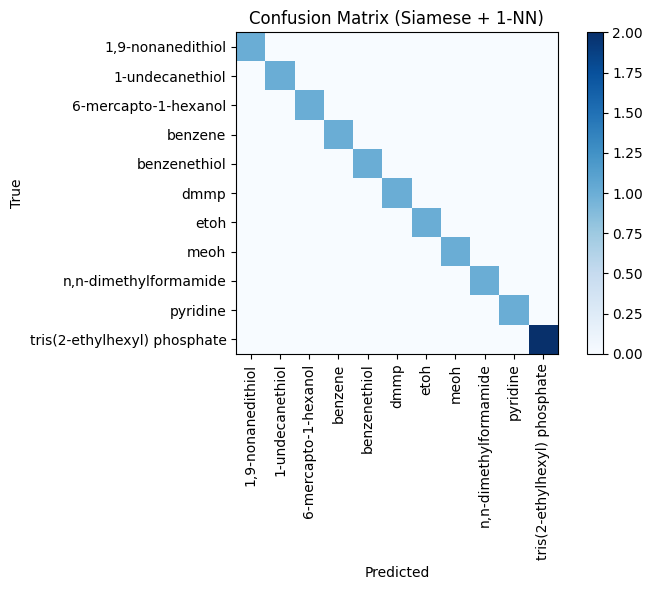

In [21]:
ref_df = pd.read_csv('reference_siamese_resampled.csv')
qry_df = pd.read_csv('query_siamese_resampled.csv')
if 'Label' not in ref_df.columns:
    ref_df.rename(columns={'Species': 'Label'}, inplace=True)
if 'Label' not in qry_df.columns:
    qry_df.rename(columns={'Species': 'Label'}, inplace=True)

wav_cols = ref_df.columns[:-1]
# numeric convert to ensure ordering
wav_cols = [col for col in wav_cols]
ref_specs = ref_df[wav_cols].values.astype(float)
qry_specs = qry_df[wav_cols].values.astype(float)
ref_labels = ref_df['Label'].values
qry_labels = qry_df['Label'].values

# 4. Preprocess spectra
ref_proc = preprocess(ref_specs)
qry_proc = preprocess(qry_specs)

# 5. Instantiate and load model
input_len = ref_proc.shape[1]
model = SiameseNet(input_len, embed_dim=64)
model.load_state_dict(torch.load("siamese_raman_resampled.pth"))
model.eval()

# 6. Compute embeddings
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 7. Nearest neighbor classification
pred1 = []
pred2 = []
for qz in qry_embeds:
    # compute distances
    dists = np.linalg.norm(ref_embeds - qz, axis=1)
    # sort ascending
    idxs = np.argsort(dists)
    pred1.append(ref_labels[idxs[0]])
    if len(idxs) > 1:
        pred2.append((ref_labels[idxs[0]], ref_labels[idxs[1]]))
    else:
        pred2.append((ref_labels[idxs[0]], None))

# 8. Compute accuracy
acc1 = accuracy_score(qry_labels, pred1)
acc2 = np.mean([qry_labels[i] in pair for i, pair in enumerate(pred2)])

print(f"Top-1 Accuracy: {acc1:.2%}")
print(f"Top-2 Accuracy: {acc2:.2%}")

# 9. Confusion matrix
labels_unique = np.unique(qry_labels)
cm = confusion_matrix(qry_labels, pred1, labels=labels_unique)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=90)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (Siamese + 1-NN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Top‑1 Acc: 100.00%, Top‑2 Acc: 100.00%


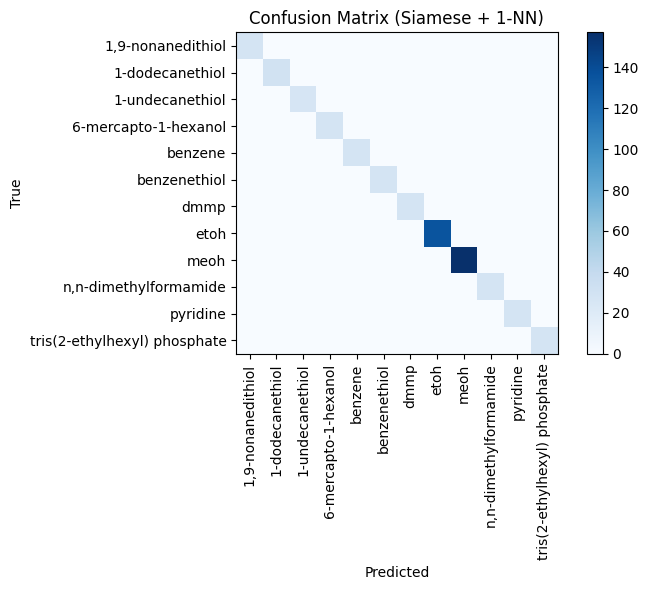

In [ ]:
# 1) Load
ref_df = pd.read_csv('reference_siamese_resampled.csv')
qry_df = pd.read_csv('reference_v2.csv')

# 2) Ensure there's a 'Label' column
for df in (ref_df, qry_df):
    if 'Label' not in df.columns:
        df.rename(columns={'Species':'Label'}, inplace=True)

# 3) Convert all wavenumber‐columns to floats (so "188.000" and "188" both become 188.0)
def floatify_cols(df):
    new_cols = []
    for c in df.columns:
        # Keep any of the exact label columns unchanged
        if c in ('Label', 'Label 1', 'Label 2'):
            new_cols.append(c)
        else:
            # Convert wavenumber strings to floats
            new_cols.append(float(c))
    df.columns = new_cols


floatify_cols(ref_df)
floatify_cols(qry_df)

# 4) Now grab the common float columns
wav_cols = sorted([c for c in ref_df.columns if c!='Label'])

# 5) Extract arrays + labels
ref_specs  = ref_df[wav_cols].values
qry_specs  = qry_df[wav_cols].values
ref_labels = ref_df['Label'].values
qry_labels = qry_df['Label'].values

# 6) Preprocess
ref_proc = preprocess(ref_specs)
qry_proc = preprocess(qry_specs)

# 7) Load model
input_len = ref_proc.shape[1]
model     = SiameseNet(input_len, embed_dim=64)
model.load_state_dict(torch.load('siamese_raman_resampled.pth'))
model.eval()

# 8) Compute embeddings
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    qry_embeds = model(torch.tensor(qry_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# 9) 1‑NN / 2‑NN classification
pred1, pred2 = [], []
for q in qry_embeds:
    d = np.linalg.norm(ref_embeds - q, axis=1)
    i = np.argsort(d)
    pred1.append(ref_labels[i[0]])
    top2 = ref_labels[i[:2]] if len(i)>1 else [ref_labels[i[0]], None]
    pred2.append(tuple(top2))

# 10) Accuracy & confusion matrix
acc1 = accuracy_score(qry_labels, pred1)
acc2 = np.mean([qry_labels[i] in p for i,p in enumerate(pred2)])
print(f"Top‑1 Acc: {acc1:.2%}, Top‑2 Acc: {acc2:.2%}")

labels_u = np.unique(qry_labels)
cm = confusion_matrix(qry_labels, pred1, labels=labels_u)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_u)), labels_u, rotation=90)
plt.yticks(range(len(labels_u)), labels_u)
plt.colorbar()
plt.title('Confusion Matrix (Siamese + 1‑NN)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()


In [47]:
def floatify_cols(df):
    new_cols = []
    for c in df.columns:
        # Keep any of the exact label columns unchanged
        if c in ('Label', 'Label 1', 'Label 2'):
            new_cols.append(c)
        else:
            # Convert wavenumber strings to floats
            new_cols.append(float(c))
    df.columns = new_cols


In [ ]:
ref_df = pd.read_csv('reference_siamese_resampled.csv')
mix_df = pd.read_csv('mixtures_dataset.csv')  # mixtures_dataset.csv must have 'Label 1' and 'Label 2'

# Ensure reference has a 'Label' column
if 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)

# Convert column names to floats where appropriate
floatify_cols(ref_df)
floatify_cols(mix_df)

# ——— 3) Identify Wavenumber Columns ———
wav_cols = sorted([c for c in ref_df.columns if c not in ['Label', 'Label 1', 'Label 2']])

# ——— 4) Extract Spectra & Labels ———
ref_specs  = ref_df[wav_cols].values
mix_specs  = mix_df[wav_cols].values
ref_labels = ref_df['Label'].values
true_pairs = list(zip(mix_df['Label 1'], mix_df['Label 2']))

# ——— 5) Preprocess Spectra ———
ref_proc = preprocess(ref_specs)
mix_proc = preprocess(mix_specs)

In [75]:
# ——— 6) Load and Prepare Siamese Network ———
input_len = ref_proc.shape[1]
model = SiameseNet(input_len, embed_dim=64)
model.load_state_dict(torch.load('siamese_raman_resampled.pth', map_location='cpu'))
model.eval()

# ——— 7) Compute Embeddings ———
with torch.no_grad():
    ref_embeds = model(torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()
    mix_embeds = model(torch.tensor(mix_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# ——— 8) 2-NN Mixture Classification ———
pred_pairs = []
for q in mix_embeds:
    dists = np.linalg.norm(ref_embeds - q, axis=1)
    idx   = np.argsort(dists)[:2]
    pred_pairs.append((ref_labels[idx[0]], ref_labels[idx[1]]))

# ——— 9) Mixture Accuracy (set match) ———
correct = sum(1 for tp, pp in zip(true_pairs, pred_pairs) if set(tp) == set(pp))
mix_acc = correct / len(true_pairs)
print(f"Mixture Identification Accuracy (Top-2 NN): {mix_acc:.2%}")

# ——— 10) Top-1 Either-Match Accuracy ———
# Count a hit if the single nearest neighbor (pred1) matches either true label
pred1 = [p[0] for p in pred_pairs]
either_hits = [
    (pr == t1) or (pr == t2)
    for (t1, t2), pr in zip(true_pairs, pred1)
]
acc1_either = np.mean(either_hits)
print(f"Top-1 Either-Match Accuracy: {acc1_either:.2%}")



Mixture Identification Accuracy (Top-2 NN): 20.86%
Top-1 Either-Match Accuracy: 98.28%


In [77]:

d1_list, d2_list, ratios = [], [], []
pred_pairs = []
for q in mix_embeds:
    dists = np.linalg.norm(ref_embeds - q, axis=1)
    idx   = np.argsort(dists)
    d1, d2 = dists[idx[0]], dists[idx[1]]
    d1_list.append(d1)
    d2_list.append(d2)
    ratios.append(d1 / d2 if d2 != 0 else np.nan)
    pred_pairs.append((ref_labels[idx[0]], ref_labels[idx[1]]))

# Create results DataFrame
results_df = pd.DataFrame({
    'True1': [t[0] for t in true_pairs],
    'True2': [t[1] for t in true_pairs],
    'Pred1': [p[0] for p in pred_pairs],
    'Pred2': [p[1] for p in pred_pairs],
    'Ratio_d1_d2': ratios,
    'Top1_EitherHit': either_hits,
    'Top2_Correct': [set(t)==set(p) for t,p in zip(true_pairs, pred_pairs)]
})


In [78]:
results_df.to_csv('mixture_predictions.csv', index=False)
print("Saved predictions and true labels to 'mixture_predictions.csv'")

Saved predictions and true labels to 'mixture_predictions.csv'


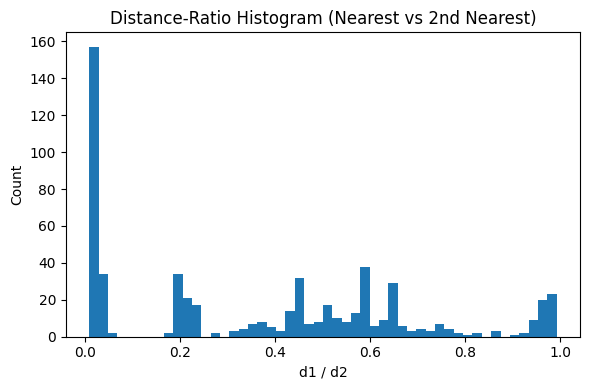

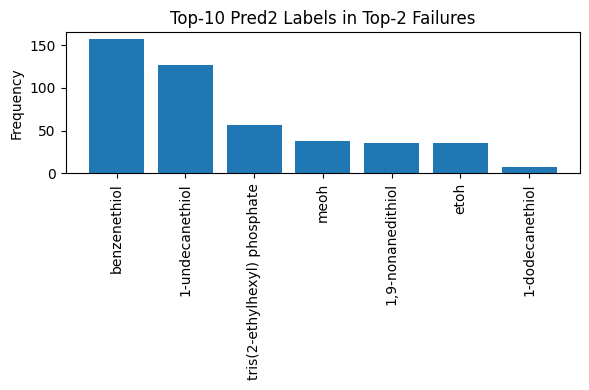

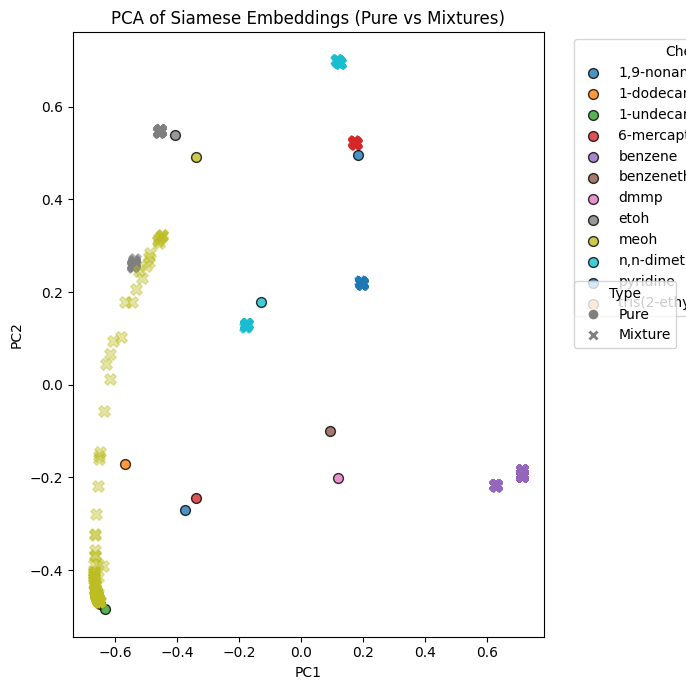

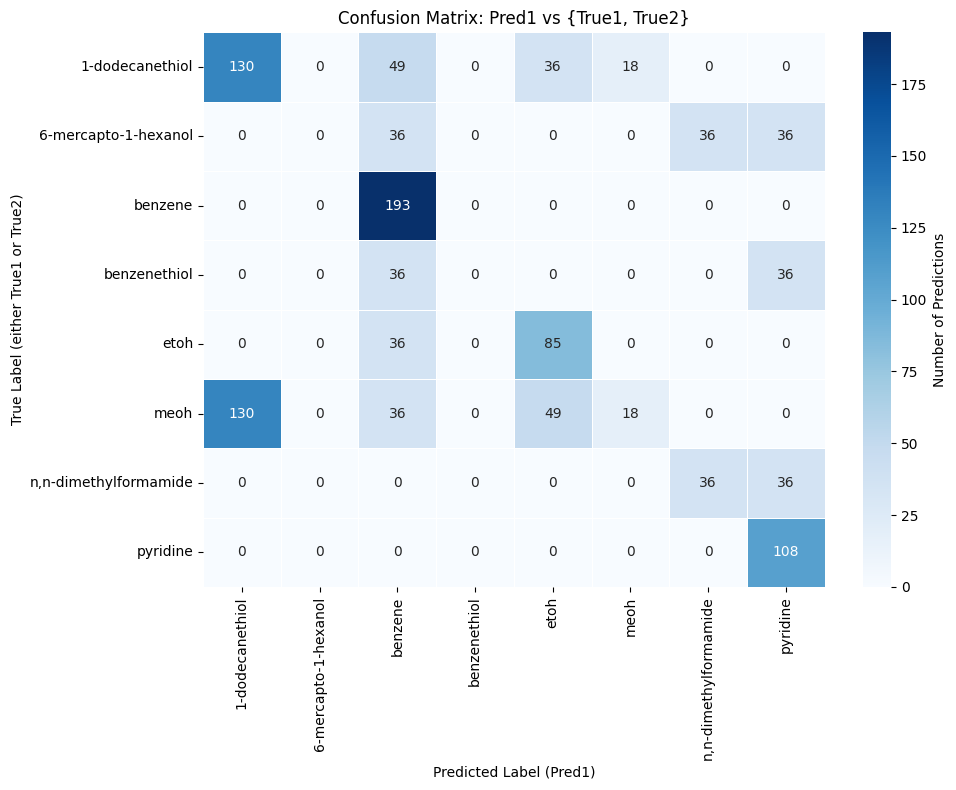

In [89]:
# ——— 4) Distance-Ratio Histogram ———
plt.figure(figsize=(6,4))
plt.hist(results_df['Ratio_d1_d2'].dropna(), bins=50)
plt.xlabel('d1 / d2')
plt.ylabel('Count')
plt.title('Distance-Ratio Histogram (Nearest vs 2nd Nearest)')
plt.tight_layout()
plt.show()

# ——— 5) Pred2 Error Bar Chart ———
errors = results_df[~results_df['Top2_Correct']]
pred2_counts = errors['Pred2'].value_counts().head(10)
plt.figure(figsize=(6,4))
plt.bar(pred2_counts.index, pred2_counts.values)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Top-10 Pred2 Labels in Top-2 Failures')
plt.tight_layout()
plt.show()

# ——— 6) Embedding Space PCA ———
from matplotlib.lines import Line2D
# 1) PCA projection
pca = PCA(n_components=2)
all_embeds = np.vstack([ref_embeds, mix_embeds])
proj = pca.fit_transform(all_embeds)

# 2) Prepare label and type arrays
labels = np.concatenate([ref_labels, mix_df['Label 1'].values])
types  = np.array(['pure']*len(ref_embeds) + ['mix']*len(mix_embeds))

# 3) Unique labels and a color map
unique_labels = np.unique(labels)
cmap = plt.get_cmap('tab10')
color_dict = {lbl: cmap(i % 10) for i, lbl in enumerate(unique_labels)}

# 4) Plot
plt.figure(figsize=(7,7))
for lbl in unique_labels:
    # pure
    idx_p = np.where((labels==lbl)&(types=='pure'))[0]
    plt.scatter(proj[idx_p,0], proj[idx_p,1],
                c=[color_dict[lbl]], marker='o', edgecolor='k',
                label=lbl, s=50, alpha=0.8)
    # mixtures
    idx_m = np.where((labels==lbl)&(types=='mix'))[0]
    plt.scatter(proj[idx_m,0], proj[idx_m,1],
                c=[color_dict[lbl]], marker='X', 
                label=None, s=70, alpha=0.4)

# 5) Build a custom legend for pure vs mix
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Pure',  markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Mixture', markerfacecolor='gray', markersize=8)
]

# 6) Place legends
first_legend = plt.legend(title='Chemical', bbox_to_anchor=(1.05,1), loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_elements, title='Type', bbox_to_anchor=(1.05,0.6), loc='upper left')

# 7) Labels & finish
plt.title('PCA of Siamese Embeddings (Pure vs Mixtures)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

df = pd.read_csv('mixture_predictions.csv')

# 2) Reconstruct true/pred lists and flatten
true_pairs = list(zip(df['True1'], df['True2']))
pred1 = df['Pred1'].tolist()

true_flat, pred_flat = [], []
for (t1, t2), p in zip(true_pairs, pred1):
    true_flat.extend([t1, t2])
    pred_flat.extend([p, p])

# 3) Define the class order
classes = sorted(set(true_flat))

# 4) Compute the confusion matrix
cm = confusion_matrix(true_flat, pred_flat, labels=classes)

# 5) Make a DataFrame so seaborn picks up row/col labels
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# 6) Plot with seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_df,
    annot=True,           # overlay the counts
    fmt='d',              # integer format
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Number of Predictions'}  # clear colorbar label
)

# 7) Tidy up labels
ax.set_title('Confusion Matrix: Pred1 vs {True1, True2}')
ax.set_xlabel('Predicted Label (Pred1)')
ax.set_ylabel('True Label (either True1 or True2)')

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [102]:
from sklearn.linear_model import ElasticNet
def elastic_net_nnls(A, b, alpha=0.001, l1_ratio=0.5):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True, max_iter=10000)
    model.fit(A, b)
    return model.coef_

In [ ]:
# ——— 5) Calibration: compute scale factors ———
classes = sorted(set(ref_labels))
baseline = classes[4] #benzene
embed_dict = {label: emb for label, emb in zip(ref_labels, ref_embeds)}

# collect ratios w_i / w_baseline for 1:1 mixtures
ratios = {chem: [] for chem in classes if chem != baseline}
for m_emb, (t1, t2) in zip(mix_embeds, true_pairs):
    if baseline in (t1, t2):
        other = t2 if t1 == baseline else t1
        A = np.vstack([embed_dict[baseline], embed_dict[other]]).T  # shape (D,2)
        w = elastic_net_nnls(A, m_emb)
        if w[0] > 0:
            ratios[other].append(w[1] / w[0])

In [ ]:
classes


['1,9-nonanedithiol',
 '1-dodecanethiol',
 '1-undecanethiol',
 '6-mercapto-1-hexanol',
 'benzene',
 'benzenethiol',
 'dmmp',
 'etoh',
 'meoh',
 'n,n-dimethylformamide',
 'pyridine',
 'tris(2-ethylhexyl) phosphate']

In [187]:
baseline = classes[5]

# Build your embed lookup and ratio‐collector
embed_dict = {label: emb for label, emb in zip(ref_labels, ref_embeds)}
ratios    = {chem: [] for chem in classes if chem != baseline}

# Collect raw ratios w_other / w_baseline on all 1:1 mixtures with baseline
for m_emb, (t1, t2) in zip(mix_embeds, true_pairs):
    if baseline in (t1, t2):
        other = t2 if t1 == baseline else t1
        A = np.vstack([embed_dict[baseline], embed_dict[other]]).T  # (D×2)
        w = elastic_net_nnls(A, m_emb)    # [w_base, w_other]
        if w[0] > 0:
            ratios[other].append(w[1] / w[0])

# Compute scale factors
scale = {baseline: 1.0}
for chem, vals in ratios.items():
    if len(vals) > 0:
        scale[chem] = 1.0 / np.median(vals)
    else:
        scale[chem] = 1.0  # or np.nan if you’d rather detect missing data


In [188]:
scaled_embeds = np.vstack([scale[label] * embed_dict[label] for label in ref_labels])

In [189]:
scaled_embeds

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.7134696 , 0.        , 0.        , 0.33402023,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03099752, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.6122421 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05991876, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.6469664 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0. 

In [190]:
# ——— 6) Reconstruction on all mixtures ———
pred_pairs = []
for m_emb in mix_embeds:
    W = elastic_net_nnls(scaled_embeds.T, m_emb)  # weights for all classes
    idx = np.argsort(W)[-2:][::-1]
    pred_pairs.append((ref_labels[idx[0]], ref_labels[idx[1]]))

In [191]:
# ——— 7) Evaluation ———
# Top-2 set-match
set_hits = [set(tp) == set(pp) for tp, pp in zip(true_pairs, pred_pairs)]
acc_top2 = np.mean(set_hits)

# Top-1 either-match
pred1 = [p[0] for p in pred_pairs]
either_hits = [pr in tp for pr, tp in zip(pred1, true_pairs)]
acc_top1 = np.mean(either_hits)

print(f"After calibration + ElasticNet:")
print(f"Top-2 Set-Match Accuracy: {acc_top2:.2%}")
print(f"Top-1 Either-Match Accuracy: {acc_top1:.2%}")

After calibration + ElasticNet:
Top-2 Set-Match Accuracy: 22.59%
Top-1 Either-Match Accuracy: 97.24%
